# **I. Import dataset**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1U1JCbYDmubyOL7pqLg1EAlWdAARvyrIK/view?usp=sharing'
file_name = 'airplane_crashes_and_fatalities_since_1908.csv'

downloaded = drive.CreateFile({'id':"1U1JCbYDmubyOL7pqLg1EAlWdAARvyrIK"})   
downloaded.GetContentFile(file_name)

# **II. Understanding data**



> [Nguồn dữ liệu](https://data.world/data-society/airplane-crashes)


Tập dữ liệu chứa thông tin của các vụ tai nạn máy bay từ năm 1908 đến nay. 

Ý nghĩa chi tiết của mỗi cột như sau:

*   Date: Ngày tháng năm diễn ra vụ tai nạn
*   Time: Thời gian diễn ra vụ tai nạn và được biểu diễn dưới dạng hh:mm
* Location: Địa điểm diễn ra vụ tai nạn
* Operator: Hãng hàng không của máy bay. Hãng hàng không có thể là quân đội, cá nhân, hoặc hàng hàng không dân sự Ví dụ như: Private, Military- U.S. Army… 
* Flight: Số hiệu của máy bay. Số hiệu này được hãng hàng không của máy bay đó quy định
* Route: Tuyến đường bay. Được biểu diễn địa điểm đầu đường bay - địa điểm cuối đường bay
* Type: Tên loại máy bay
* Registration: Mã seri đăng ký máy bay được ICAO (tổ chức hàng không dân dụng quốc tế cấp)
* Cn_in: Cn: construction number | In: Line number. Cn_in gồm mã seri được cấp bởi nhà sản xuất máy bay và mã số hiệu của thân máy hoặc dòng thể loại của máy bay
* Aboard: Tổng lượng người trên chuyến bay (bao gồm cả hành khách và phi hành đoàn)
* Fatalities: số ca tử vong trong vụ tai nạn
* Ground: số ca dưới mặt đất khi bị máy bay rơi xuống làm tử vong
* Summary: kết luận của cơ quan điều tra về nguyên nhân xảy ra tai nạn





**Yêu cầu phân tích**: Xây dựng mô hình Học máy để dự đoán và phân loại mức độ nghiêm trọng
của bất kỳ tai nạn máy bay nào dựa trên các sự cố trong quá khứ.

# **III. Exploring data**

##  1/ Exploring null and duplicate data

In [ ]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime,time
import pandas as pd

df=pd.read_csv(file_name)

#Nhìn khái quát những dòng đầu tiên của tập dữ liệu
print('Số cột của tập dữ liệu:', df.shape[1])
print('Số dòng của tập dữ liệu:',df.shape[0])
df.head(10)

Số cột của tập dữ liệu: 13
Số dòng của tập dữ liệu: 5268


,date,time,location,operator,flight,route,type,registration,cn_in,aboard,fatalities,ground,summary
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,1913-09-09,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...
5,1915-03-05,01:00,"Tienen, Belgium",Military - German Navy,NaN,NaN,Zeppelin L-8 (airship),NaN,NaN,41.0,21.0,0.0,Crashed into trees while attempting to land af...
6,1915-09-03,15:20,"Off Cuxhaven, Germany",Military - German Navy,NaN,NaN,Zeppelin L-10 (airship),NaN,NaN,19.0,19.0,0.0,"Exploded and burned near Neuwerk Island, when..."
7,1916-07-28,NaN,"Near Jambol, Bulgeria",Military - German Army,NaN,NaN,Schutte-Lanz S-L-10 (airship),NaN,NaN,20.0,20.0,0.0,"Crashed near the Black Sea, cause unknown."
8,1916-09-24,01:00,"Billericay, England",Military - German Navy,NaN,NaN,Zeppelin L-32 (airship),NaN,NaN,22.0,22.0,0.0,Shot down by British aircraft crashing in flames.
9,1916-10-01,23:45,"Potters Bar, England",Military - German Navy,NaN,NaN,Zeppelin L-31 (airship),NaN,NaN,19.0,19.0,0.0,Shot down in flames by the British 39th Home D...


**Nhận xét**:


* Dữ liệu 5268 dòng và 13 cột dữ liệu đầu vào  
* Cột Flight, Route, Registration, cn/In  dữ liệu bị mất tương đối nhiều
*   Tần suất xuất hiện của hãng máy bay Military – German Navy tương đối nhiều.





In [ ]:
# Thống kê dữ liệu null
print('Phần trăm dữ liệu null ở mỗi cột:\n')
round((df.isnull().sum()*100)/5268,2) 

Phần trăm dữ liệu null ở mỗi cột:



date             0.00
time            42.12
location         0.38
operator         0.34
flight          79.71
route           32.38
type             0.51
registration     6.36
cn_in           23.31
aboard           0.42
fatalities       0.23
ground           0.42
summary          7.40
dtype: float64

* Dựa vào thống kê ở trên ta nhận thấy rằng cột Flight bị mất dữ liệu nhiều nhất, chiếm tới 79.71%
* Bên cạnh đó các cột như Time, route, cn_in cũng bị khuyết dữ liệu ở một ngưỡng đáng kể
* Đối với các cột còn lại thì dữ liệu bị khuyết tương đối ít, không chiếm quá 1%



In [ ]:
#Thống kê trùng lắp dữ liệu
df.duplicated().sum()

0

* Không có dữ liệu bị trùng lắp

##  2/ Exploring distribution of data

In [ ]:
#Tìm min, max, std của các cột và nhận xét
df.describe()

,aboard,fatalities,ground
count,5246.000000,5256.000000,5246.000000
mean,27.554518,20.068303,1.608845
std,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000
50%,13.000000,9.000000,0.000000
75%,30.000000,23.000000,0.000000
max,644.000000,583.000000,2750.000000


Ta nhận thấy cả 3 cột Aboard, Fatalities, Ground đều có sự chênh lệch lớn giữa giá trị lớn nhất và giá trị nhỏ nhất.


---

**Cột Aboard** (số người trên chuyến bay)

*   Số người trên chuyến bay dao động từ 0 - 644
*   Độ lệch chuẩn lớn hơn nhiều so với giá trị trung bình (43>27)
* Có thể nói dữ liệu phân bố không đều và có xu hướng lệch phải

---

**Cột Fatalities** (Số ca tử vong trong vụ tai nạn)


*   Số ca tử vong trong vụ tai nạn dao động từ 0 - 583 người
*   Số ca tử vong trung bình khoảng 20 ca ít hơn so với độ lệch chuẩn (33.2%) nên có thể thấy dữ liệu sẽ hơi lệch về bên phải

---

**Cột Ground** (Số ca tử vong dưới mặt đất do máy bay rơi xuống)

* Số ca tử vong dưới mặt đất do máy bay rơi xuống dao động từ 0 - 2750 ca
* Số ca tử vong trung bình là 1.6 ít hơn nhiều so với độ lệch chuẩn (54.00%) nên có thể thấy dữ liệu sẽ bị lệch về bên phải

### **a. Abroad column**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


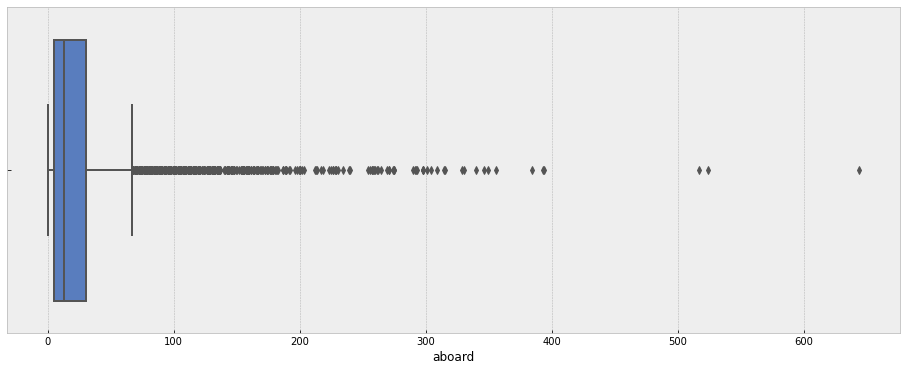

In [ ]:
plt.figure(figsize=(16,6))

sns.boxplot(df['aboard'])

* Biểu đồ có nhiều giá trị outlier và lệch phải. Tuy nhiên dữ liệu ở cột này thể hiện số người trên chuyến bay và trên thực tế sức chứa của một máy bay có thể lên tới 800 nên những giá trị này có thể không phải là outlier
* Dữ liệu tập trung ở 50% sau
* Dữ liệu trải dài và phân tán không đều

In [ ]:
df[df['aboard']>500]

,date,time,location,operator,flight,route,type,registration,cn_in,aboard,fatalities,ground,summary
2963,1977-03-27,17:07,"Tenerife, Canary Islands",Pan American World Airways / KLM,1736/4805,Tenerife - Las Palmas / Tenerife - Las Palmas,Boeing B-747-121 / Boeing B-747-206B,N736PA/PH-BUF,19643/11 / 20400/157,644.0,583.0,0.0,Both aircraft were diverted to Tenerife becaus...
3568,1985-08-12,18:56,"Mt. Osutaka, near Ueno Village, Japan",Japan Air Lines,123,Tokyo - Osaka,Boeing B-747-SR46,JA8119,20783/230,524.0,520.0,0.0,The aircraft suffered an aft pressure bulkhead...
4645,1999-07-23,11:25,"Tokyo, Japan",All Nippon Airways,61,"Tokyo, Japan - Chitose, Japan",Boeing B-747,NaN,NaN,517.0,1.0,0.0,Two minutes after taking off from Haneda Airpo...


Text(0.5, 1.0, 'Histogram of Aboard')

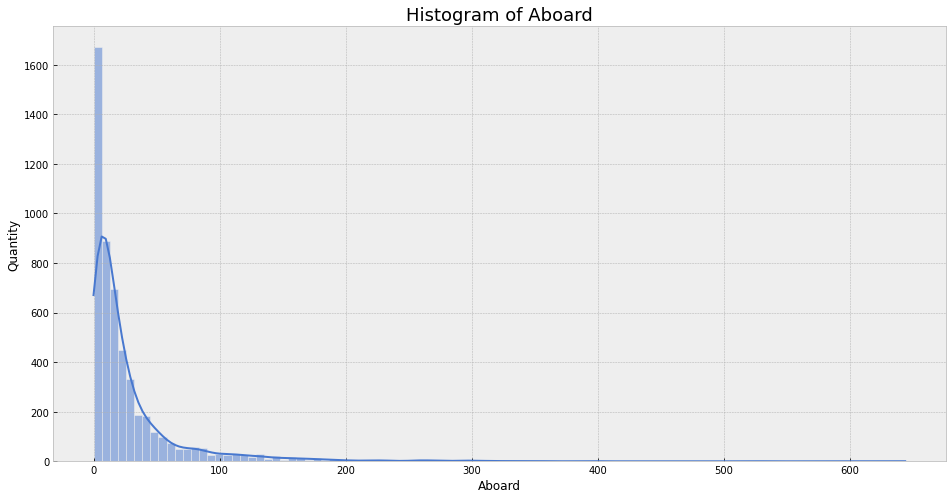

In [ ]:
#Biểu đồ minh họa cho các giá trị min max

#ground = df['aboard'].value_counts()
#print(ground,'\n')

plt.figure(figsize=(16, 8))
sns.histplot(x='aboard', data = df, bins=100, kde = True)
plt.xlabel('Aboard', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title("Histogram of Aboard", fontsize=18)

### **b.Fatalities column**

In [ ]:
df[df.fatalities > df.aboard].shape[0]

0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


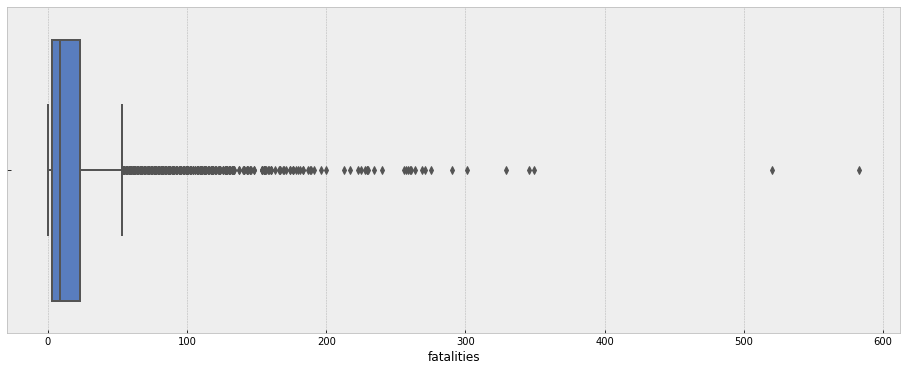

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(df['fatalities'])

* Nhận thấy rằng trong tập dữ liệu không có những dòng nào mà số người tử vong > số người trên máy bay
* Biểu đồ boxplot fatalities lệch phải
* Có nhiều giá trị outlier với nhiều giá trị phân bố trải dài từ 0 đến 600.
* Biểu đồ phân tán không đồng đều
* Dữ liệu phân bố ở 50% sau.

Text(0.5, 1.0, 'Histogram of Fatalities')

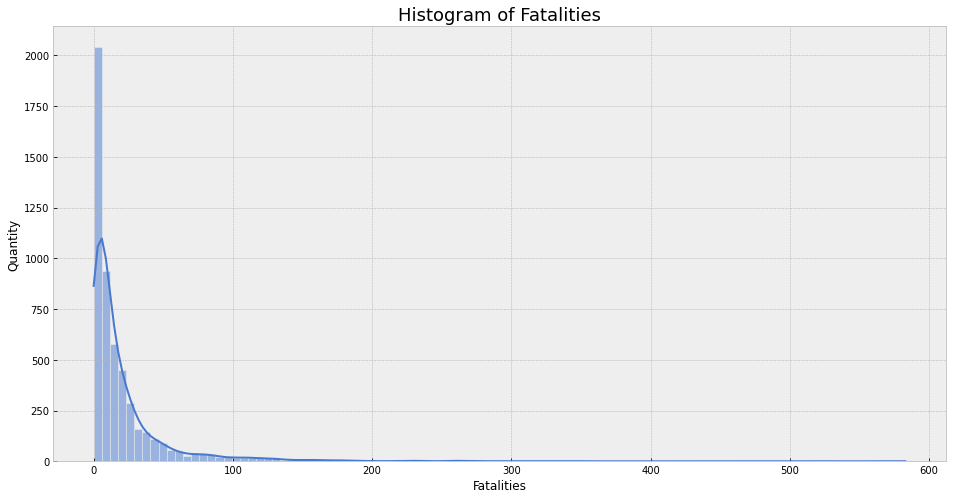

In [ ]:
#Biểu đồ minh họa cho các giá trị min max

#ground = df['Fatalities'].value_counts()
#print(ground,'\n')
plt.figure(figsize=(16, 8))
sns.histplot(x='fatalities', data = df, bins=100, kde=True)
plt.xlabel('Fatalities', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title("Histogram of Fatalities", fontsize=18)

### **c. Ground column**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


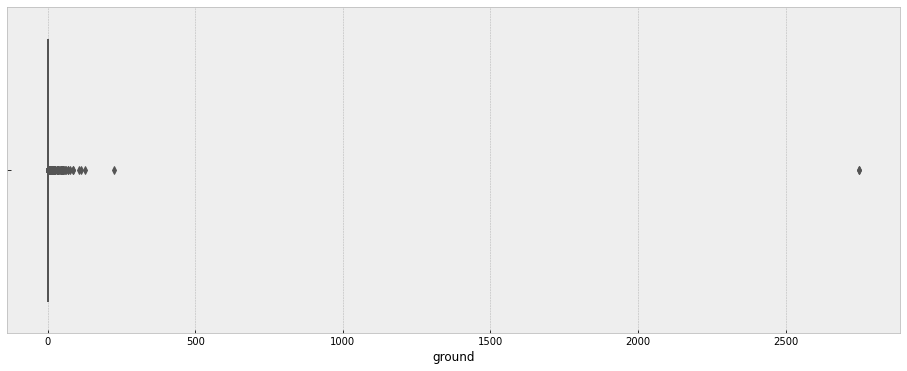

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(df['ground'])

Text(0.5, 1.0, 'Histogram of Ground')

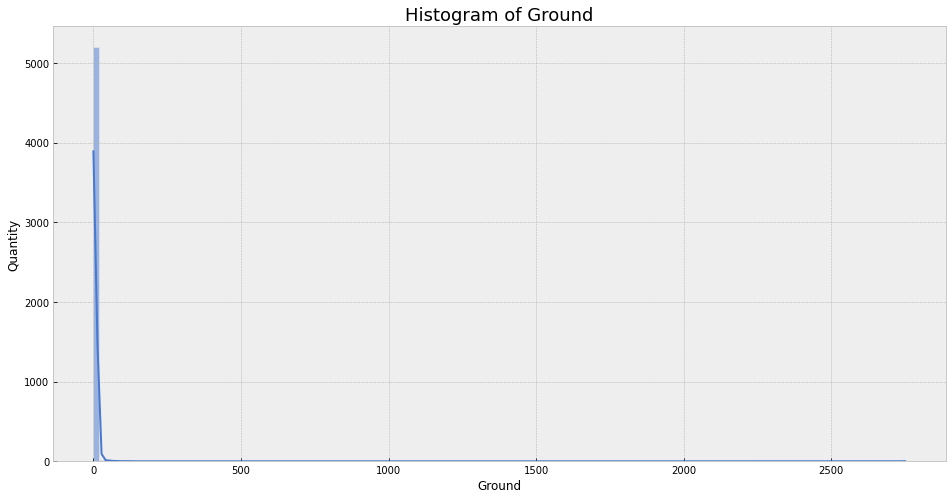

In [ ]:
# ground = df['ground'].value_counts()
# print(ground,'\n')

plt.figure(figsize=(16, 8))
sns.histplot(x='ground', data = df, bins=150, kde=True)
plt.xlabel('Ground', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title("Histogram of Ground", fontsize=18)

In [ ]:
print ('Số dòng có ground = 0:', df[df['ground'] ==0].shape[0], '\n')
df[df['ground'] >2500]

Số dòng có ground = 0: 5027 



,date,time,location,operator,flight,route,type,registration,cn_in,aboard,fatalities,ground,summary
4803,2001-09-11,08:47,"New York City, New York",American Airlines,11,Boston - Los Angeles,Boeing 767-223ER,N334AA,22332/169,92.0,92.0,2750.0,The aircraft was hijacked shortly after it lef...
4804,2001-09-11,09:03,"New York City, New York",United Air Lines,175,Boston - Los Angeles,Boeing B-767-222,N612UA,21873/41,65.0,65.0,2750.0,The aircraft was hijacked shortly after it lef...


**Nhận xét**:
* Ta nhận thấy dữ liệu phân bố không đồng đều và tập trung phần lớn tại giá trị 0
* Thông qua biểu đồ boxplot ta nhận thấy có các outlier xuất hiện với giá trị > 2500. Ta đặt nghi vấn đây có thể là một outlier. 
* Ta chọn các dòng đó ra trong tập dữ liệu để tìm hiểu và ta nhận thấy rằng thời gian xảy ra vụ tai nạn này là vào ngày 09/11/2001, cùng với địa điểm là New York thì ta khẳng định đây chính là 2 chiếc máy bay trong sự kiện khủng bố tại Mỹ nên dữ liệu này không phải là outlier

### **d. Operator column**

Others      5268
Military     781
Private       81
Name: index, dtype: int64 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Percentage of Operator')

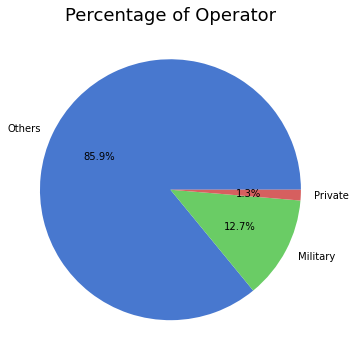

In [ ]:
#Thống kê Operator
S1=df.loc[df['operator'].str.contains('Private', na=False)]
S1['index']='Private'
df.iloc[:,3]
S2=df.loc[df['operator'].str.contains('Military', na=False)]
S2['index']='Military'
df.iloc[:,3]
S3=df.loc[~(df['operator'].str.contains('Military', na=False)&df['operator'].str.contains('Private', na=False))]
S3['index']='Others'
operator = S1.append(S2).append(S3)['index'].value_counts()
print(operator,'\n')
plt.figure(figsize=(16, 6))
plt.pie(operator,
        labels = operator.index, # Nhãn của các nhóm
        autopct = '%1.1f%%', # Format hiển thị giá trị %
        shadow = False)
plt.title("Percentage of Operator", fontsize=18)

**Nhận xét**:
* Ta nhận thấy rằng số vụ tai nạn của những phi cơ tư nhân chiếm tỉ trọng thấp (1.3%)
* Tỉ trọng của những vụ tai nạn bởi phi cơ dùng trong mục đích quân sự chiếm tỉ lệ tương đối (12.7%)
* Phần còn lại chiếm tỉ lệ đông nhất chính là những phi cơ phục vụ dân sự hay mục đích thương mại

## **3/ Another exploring**

### **a. Accident by year**

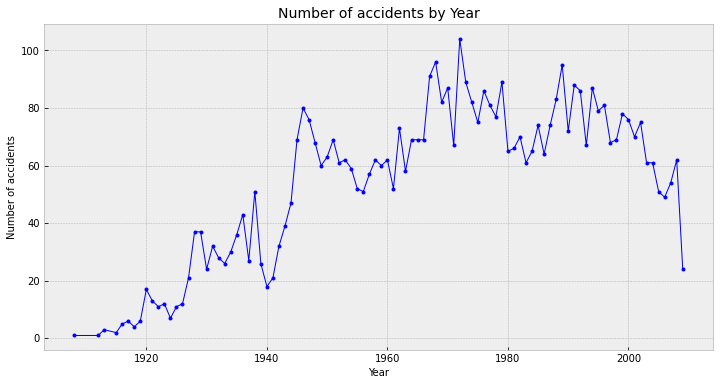

In [ ]:
# Vẽ biểu đồ số vụ tai nạn theo từng năm
df['date'] = pd.to_datetime(df['date'], errors='coerce')
Temp = df.groupby(df.date.dt.year)[['date']].count() #Temp is going to be temporary data frame 
Temp = Temp.rename(columns={"date": "Count"})

plt.figure(figsize=(12,6))
plt.style.use('bmh')
plt.plot(Temp.index, 'Count', data=Temp, color='blue', marker = ".", linewidth=1)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of accidents', fontsize=10)
plt.title('Number of accidents by Year', loc='Center', fontsize=14)
plt.show()

**Nhận xét**:

* Biểu đồ cho thấy số vụ tai nạn hằng năm tăng giảm không đồng đều.  Sau những năm 2000 số vụ tai nạn có xu hướng giảm.
* Số vụ tai nạn tăng cao và nhanh chóng vào những năm có chiếm tranh 1945,1975.
* Biểu đồ từ trước năm 1920 đến 1940 bắt đầu tăng chậm theo từng năm.
* Biểu đồ từ năm 1960 đến trước những năm 2000 luôn duy trì ở mức trên 60 vụ mỗi năm.


### **b. Fatal people by year**

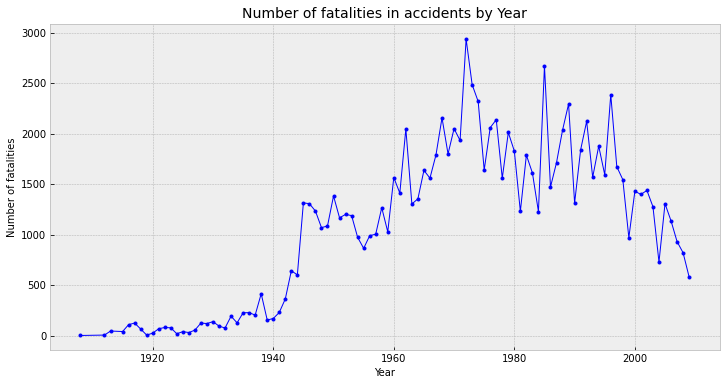

In [ ]:
# Vẽ biểu đồ số người tử vong theo từng năm
df['date'] = pd.to_datetime(df['date'], errors='coerce')
Temp = df.groupby(df.date.dt.year)[['fatalities']].sum() #Temp is going to be temporary data frame 
Temp = Temp.rename(columns={"fatalities": "Count"})
plt.figure(figsize=(12,6))
plt.style.use('bmh')
plt.plot(Temp.index, 'Count', data=Temp, color='blue', marker = ".", linewidth=1)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of fatalities', fontsize=10)
plt.title('Number of fatalities in accidents by Year', loc='Center', fontsize=14)
plt.show()

**Nhận xét**: 
* Số người tử vong mỗi năn tang giảm không đồng đều. Sau năm 2000 có xu hướng giảm.
* Biểu đồ giao động lớn với số ca từ 0 đến 3000. từ những năm trước 1920 đến 1940 nhìn chung số nạn nhân duy trì ở mức dưới 500.
* Sau 1940 đến 2000 số nạn nhân luôn tăng giảm không đồng đều nhưng luôn duy trì ở mức cao. Từ 500 đến gần 3000.
* Từ năm 1960 đến 2000 số nạn nhân luôn ở mức trên 1000.
Đỉnh điểm là vào những năm 1975 số ca gần mức 3000.

### **c. Fatal people on ground by year**

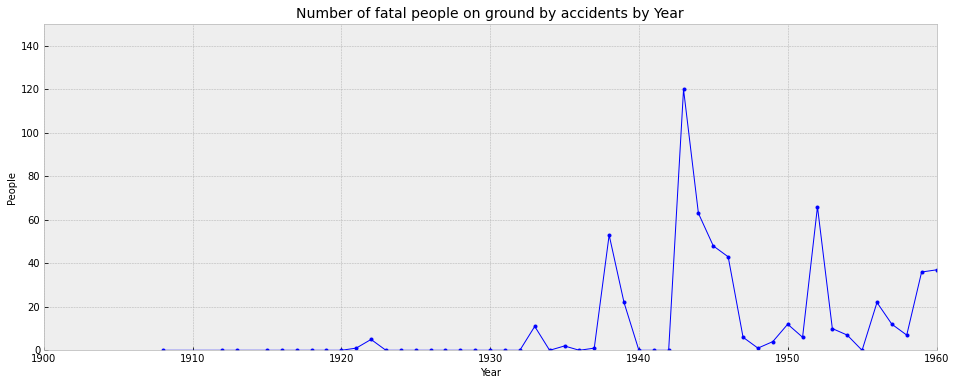

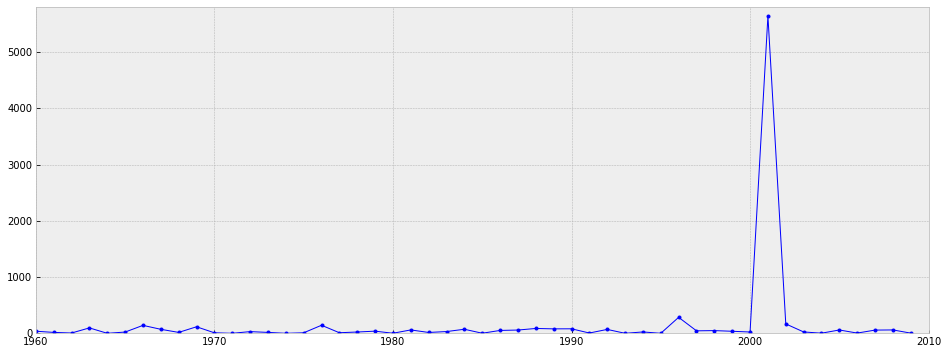

In [ ]:
# Biểu đồ số lượng người tử vong trên mặt đất do các vụ tai nạn gây ra mỗi năm
df['date'] = pd.to_datetime(df['date'], errors='coerce')
Temp = df.groupby(df.date.dt.year)[['ground']].sum() #Temp is going to be temporary data frame 
Temp = Temp.rename(columns={"ground": "Count"})
plt.figure(figsize=(16,6))
plt.style.use('bmh')
plt.xlim([1900,1960])
plt.ylim([0,150])
plt.plot(Temp.index, 'Count', data=Temp, color='blue', marker = ".", linewidth=1)
plt.xlabel('Year', fontsize=10)
plt.ylabel('People', fontsize=10)
plt.title('Number of fatal people on ground by accidents by Year', loc='Center', fontsize=14)
plt.show()
plt.figure(figsize=(16,6))
plt.xlim([1960,2010])
plt.ylim([0,5800])
plt.plot(Temp.index, 'Count', data=Temp, color='blue', marker = ".", linewidth=1)
plt.show()

**Nhận xét**:
* Biểu đồ tăng giảm không đồng đều. 
* Biểu đồ có giá trị từ 0 đến hơn 5000 nạn nhân/ năm.
* Số nạn nhân vào các năm sau 1940 và sau những năm 2000 tăng cao nhanh chóng so với những năm trước đó.
* Biểu đồ từ trước năm 1910 đến 1935 ổn định ở mức dưới 20 người.

### **d. Accident by month**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of accidents by Month')

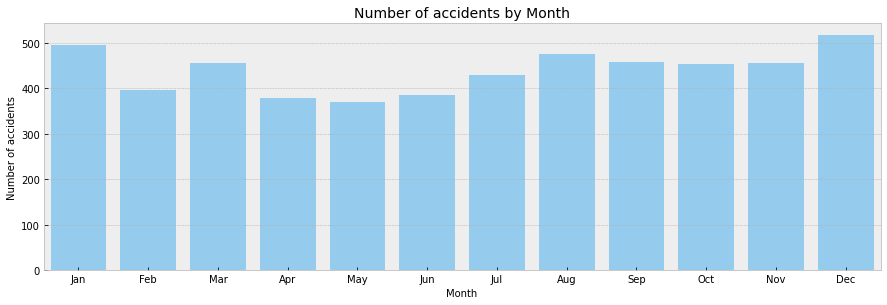

In [ ]:
# Biểu đồ số vụ tai nạn máy bay vào các tháng trong năm
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 2)
pl.figure(figsize=(15,10))
plt.style.use('seaborn-muted')
ax = pl.subplot(gs[0, :]) # row 0, col 0
sns.barplot(df.groupby(df.date.dt.month)[['date']].count().index, 'date', data=df.groupby(df.date.dt.month)[['date']].count(), color='lightskyblue', linewidth=2)
plt.xticks(df.groupby(df.date.dt.month)[['date']].count().index-1, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month', fontsize=10)
plt.ylabel('Number of accidents', fontsize=10)
plt.title('Number of accidents by Month', loc='Center', fontsize=14)

**Nhận xét**:
* Biểu đồ tăng giảm không đều luôn giao động từ 350 – 500 ca.
* Vào các tháng 1, 8, 12 số tai nạn xảy ra nhiều nhất trong năm. Số vụ tai nạn đầu và cuối hàng năm là cao nhất trong năm.
* Vào các tháng 4, 5, 6 số vụ tai nạn ít nhất trong năm.
* Từ tháng 7 đến tháng 11 số vụ tai nạn duy trì ở mức cao hơn 400.

## **4. Exploring correlation**

### **a. Overview**

Text(0.5, 1.0, 'Correlation between columns')

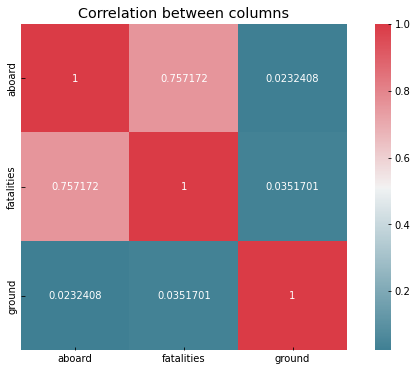

In [ ]:
corr = df.corr()
f, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True, fmt = 'g')
plt.title('Correlation between columns')

**Nhận xét:**
* Dễ dàng nhận thấy rằng giữa cột Aboard và Fatalities có một mối tương quan khá mạnh lên tới 0.75. 
* Đối với các cột còn lại ta nhận thấy rằng mối tương quan giữa chúng tương đối kém

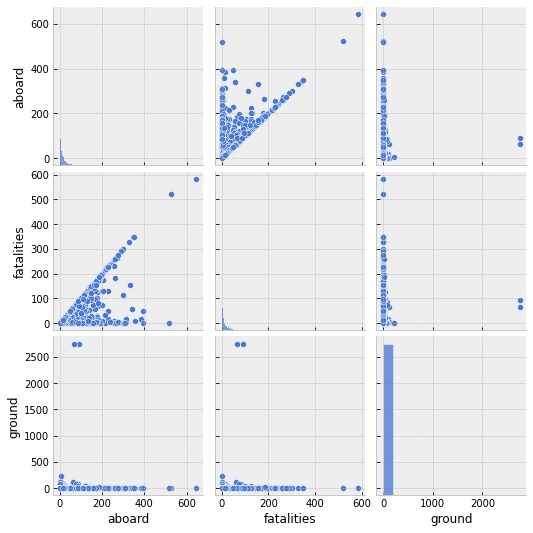

In [ ]:
sns.pairplot(df)

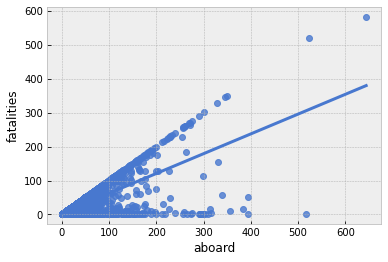

In [ ]:
sns.regplot(y = "fatalities",x='aboard', ci= None, data = df)

Thông qua biểu đồ Scatter plot ta sẽ nhận thấy được rẳng mối quan hệ giữa aboard và fatalities là một mối quan hệ đồng biến. Khi một giá trị tăng thì giá trị còn lại sẽ tăng theo.

### **b. Finding regression expression between columns**

**Regression between aboard and fatalities**

In [ ]:
import statsmodels.api as sm

#Lấy những dòng dữ liệu không null
ndf = df[['aboard','fatalities']].dropna()
X = ndf['aboard']
X = sm.add_constant(X)
Y = ndf['fatalities']
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             fatalities   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     7046.
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:36:19   Log-Likelihood:                -23585.
No. Observations:                5246   AIC:                         4.717e+04
Df Residuals:                    5244   BIC:                         4.719e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9981      0.356     11.243      0.0

Thông qua các phép toán ta tìm được biểu thức hồi quy giữa cột aboard và fatalities như sau:
* Fatalities = 3.9981 + 0.5838 * Aboard

Với độ R-squared là 57.3% chúng ta có thể đánh giá mô hình hồi quy này tương đối tốt

**Regression between Fatalities and Aboard**

In [ ]:
X = ndf['fatalities']
X = sm.add_constant(X)
Y = ndf['aboard']
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 aboard   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     7046.
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:36:19   Log-Likelihood:                -24950.
No. Observations:                5246   AIC:                         4.990e+04
Df Residuals:                    5244   BIC:                         4.992e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8308      0.454     17.246      0.0

Tương tự ngược lại ta cũng tìm được một biểu thức hồi quy giữa Fatalities và Aboard như sau:
* Aboard = 7.8308 + 0.9821 * Fatalities

Với độ R-squared là 57.3% thì ta có thể chấp nhận đường hồi quy này

# **III. Cleansing data**


Ta sẽ giữ lại những cột có ít giá trị null để sử dụng, bao gồm các cột:
* Date
* Aboard
* Fatalities
* Ground

In [ ]:
cdf = df[['aboard','fatalities','ground']]
cdf.shape[0]

5268

Để điền vào những giá trị null trong tập dữ liệu thì đối với từng cột ta có cách giải quyết như sau:
* Cột Ground sẽ thay thế bằng mode của tập dữ liệu, tức giá trị 0
* Đối với cột Aboard và Fatalities ta sẽ thay thế bằng những biểu thức hồi quy đã tìm được phía trên
* Nếu cả hai cột Aboard và Fatalities đều trống thì ta sẽ điền cột Aboard bằng giá trị trung bình của cột đó và dùng biểu thức hồi quy để điền vào giá trị của cột Fatalities

In [ ]:
#Fill N.A cho cột groud
cdf['ground'].fillna(0, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
#Fill NA cho cột Aboard

two_null = cdf[cdf['aboard'].isnull() & cdf['fatalities'].isnull()]
one_null = cdf[cdf['aboard'].isnull() & ~cdf['fatalities'].isnull()]
non_null = cdf[~cdf['aboard'].isnull()]

mean_aboard = round(cdf['aboard'].mean(),0)
two_null["aboard"].fillna(round(mean_aboard,0), inplace = True)
one_null['aboard'].fillna(round(one_null['fatalities']*0.9821 + 7.8308,0), inplace = True)

cdf = pd.concat([non_null,one_null,two_null])
cdf = cdf.sort_index()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
#Fill NA cho cột Fatalities

cdf['fatalities'].fillna(round(cdf['aboard']*0.5838 + 3.9981,0), inplace = True)
cdf.isnull().sum()

aboard        0
fatalities    0
ground        0
dtype: int64

# **IV. Classification**

Dựa vào các giá trị Aboard, Fatalities và Ground ta thể tạm thời gắn nhãn cho các vụ tai nạn như sau:
* Major Accident
* Fatal Accident
* Minor Accident 
---
Tiêu chí phân loại của từng nhóm như sau:
* **Minor accident**: không có người thương vong
* **Major accident**: hơn 60% số người trên chuyến bay bị thiệt mạng hoặc hơn 30 người tử vong
* **Fatal accident**: số người thiệt mạng ít hơn 60%

Tạo thêm 1 cột mới tính tổng số người thương vong


In [ ]:
cdf['Total fatalities'] = cdf.apply(lambda row: row.fatalities + row.ground, axis=1)
cdf

,aboard,fatalities,ground,Total fatalities
0,2.0,1.0,0.0,1.0
1,5.0,5.0,0.0,5.0
2,1.0,1.0,0.0,1.0
3,20.0,14.0,0.0,14.0
4,30.0,30.0,0.0,30.0
...,...,...,...,...
5263,112.0,98.0,2.0,100.0
5264,4.0,4.0,0.0,4.0
5265,228.0,228.0,0.0,228.0
5266,1.0,1.0,0.0,1.0


Gán nhãn cho từng dòng

In [ ]:
def severity (row):
  if row['Total fatalities'] == 0:
    return 'Minor accident'
  if row['Total fatalities'] >= 30 or (row['aboard'] != 0 and row['fatalities']/row['aboard'] >= 0.6):
    return 'Major accident'
  else:
    return 'Fatal accident'

cdf['Severity'] = cdf.apply(lambda row: severity(row), axis=1)
cdf['Severity'].value_counts()

Major accident    4354
Fatal accident     877
Minor accident      37
Name: Severity, dtype: int64

Sau khi đã phân loại mức độ nghiêm trọng của từng vụ tai nạn, ta sẽ sử dụng mô hình Decision Tree xây dựng model phân loại những vụ tai nạn này

In [ ]:
#Import thư viện
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# X -> features, y -> label
X = cdf[['aboard','fatalities','ground']]
y = cdf.Severity

# training a DescisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1234, max_depth=3)
scaler = StandardScaler()


# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.2)

#Standardlize data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Số nhãn trong tập train:\n', y_train.value_counts())
print('\nSố nhãn trong tập test:\n',y_test.value_counts())

Số nhãn trong tập train:
 Major accident    3466
Fatal accident     716
Minor accident      32
Name: Severity, dtype: int64

Số nhãn trong tập test:
 Major accident    888
Fatal accident    161
Minor accident      5
Name: Severity, dtype: int64


In [ ]:
#Cross validation
dtree_model = clf.fit(X_train, y_train)
kf = KFold(n_splits=10)
scores = cross_val_score(dtree_model, X_train, y_train, cv=kf)

print("The model with %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()*100))

[0.92890995 0.92180095 0.94549763 0.95260664 0.94536817 0.94299287
 0.94061758 0.9216152  0.91448931 0.90736342]
The model with 93.21 accuracy with a standard deviation of 1.45


**Mô hình cây quyết định**

[Text(697.5, 951.3000000000001, 'fatalities <= -0.559\ngini = 0.295\nsamples = 4214\nvalue = [716, 3466, 32]\nclass = Major accident'),
 Text(348.75, 679.5, 'aboard <= -0.601\ngini = 0.551\nsamples = 379\nvalue = [214, 133, 32]\nclass = Fatal accident'),
 Text(174.375, 407.70000000000005, 'fatalities <= -0.589\ngini = 0.043\nsamples = 135\nvalue = [3, 132, 0]\nclass = Major accident'),
 Text(87.1875, 135.89999999999998, 'gini = 0.5\nsamples = 6\nvalue = [3, 3, 0]\nclass = Fatal accident'),
 Text(261.5625, 135.89999999999998, 'gini = 0.0\nsamples = 129\nvalue = [0, 129, 0]\nclass = Major accident'),
 Text(523.125, 407.70000000000005, 'fatalities <= -0.589\ngini = 0.235\nsamples = 244\nvalue = [211, 1, 32]\nclass = Fatal accident'),
 Text(435.9375, 135.89999999999998, 'gini = 0.352\nsamples = 41\nvalue = [8, 1, 32]\nclass = Minor accident'),
 Text(610.3125, 135.89999999999998, 'gini = 0.0\nsamples = 203\nvalue = [203, 0, 0]\nclass = Fatal accident'),
 Text(1046.25, 679.5, 'fatalities <= 

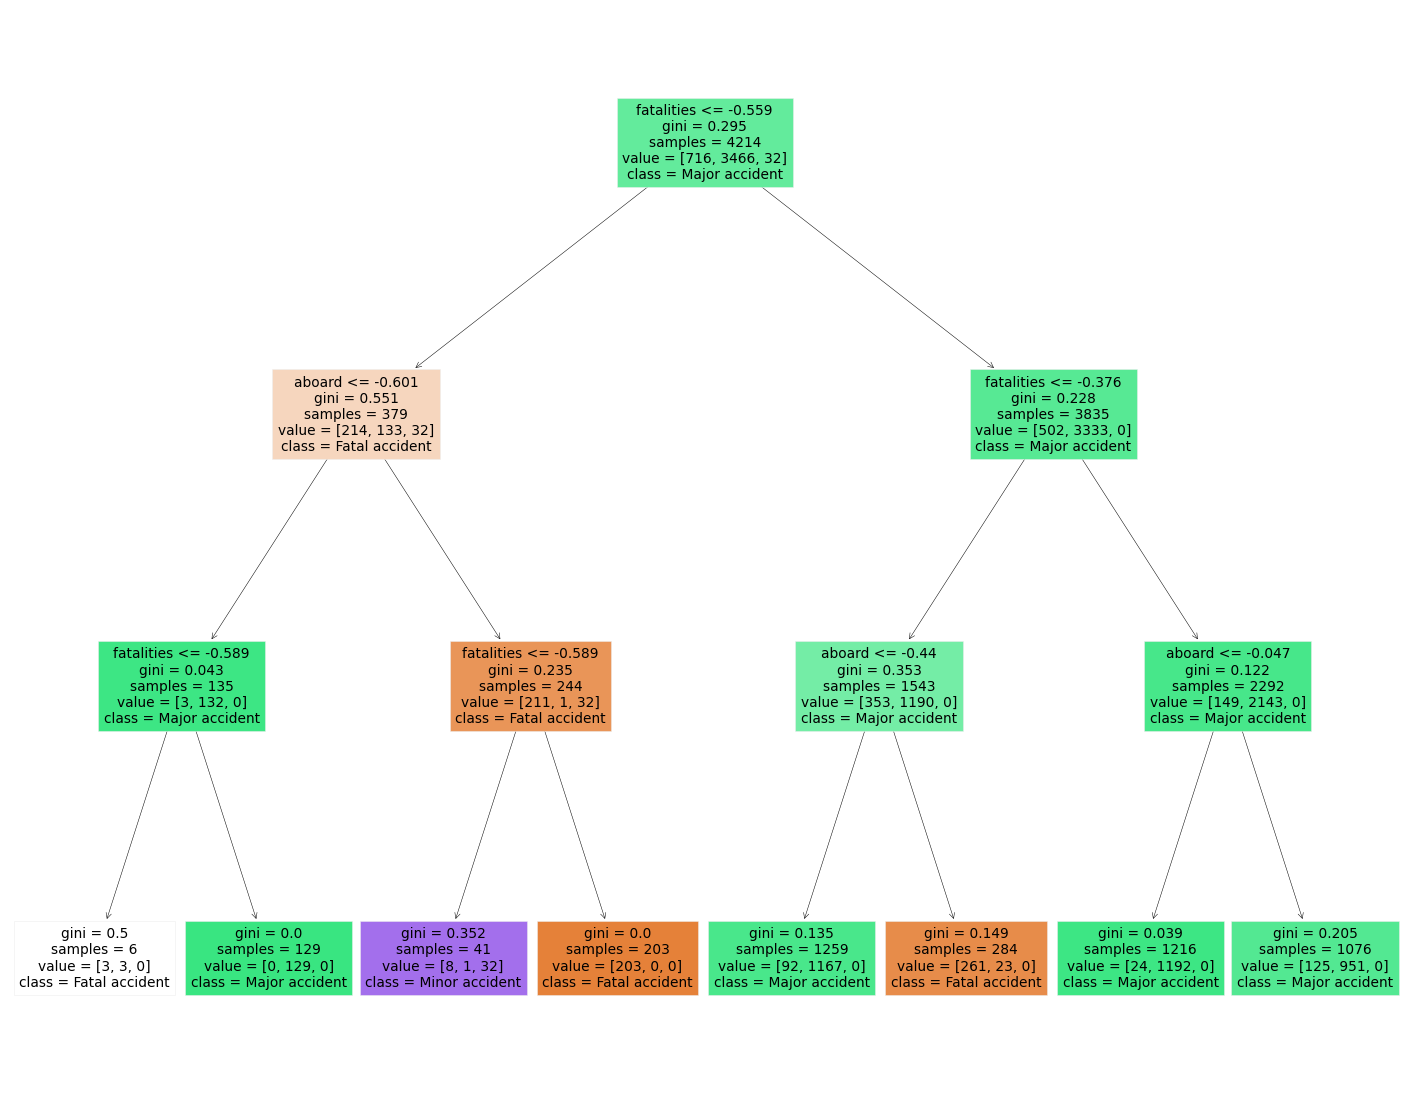

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dtree_model, 
               feature_names=['aboard','fatalities', 'ground'],
               class_names = ['Fatal accident','Major accident', 'Minor accident'],
               filled = True)

**Test lại với tập test**

In [ ]:
dtree_predictions = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


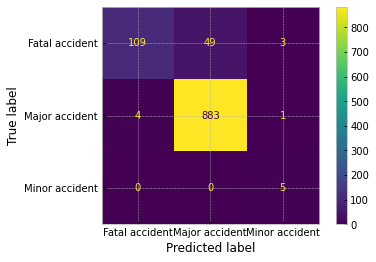

In [ ]:
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)
plot_confusion_matrix(clf, X_test, y_test)

In [ ]:
print(classification_report(y_test, dtree_predictions))

                precision    recall  f1-score   support

Fatal accident       0.96      0.68      0.80       161
Major accident       0.95      0.99      0.97       888
Minor accident       0.56      1.00      0.71         5

      accuracy                           0.95      1054
     macro avg       0.82      0.89      0.83      1054
  weighted avg       0.95      0.95      0.94      1054



Độ chính xác của mô hình trên tập test là 95%

Dựa vào biểu đồ trên ta nhận thấy được rằng tỉ lệ nhận diện đúng của từng nhãn như sau:
* Fatal: 96%
* Major: 95%
* Minor: 56%


Bên cạnh đó chúng ta còn nhận thấy được phần trăm giá trị bị bỏ sót như sau:
* Fatal: 68%
* Major: 99%
* Minor: 100%

# **V. References**



*   https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/
*   https://www.statology.org/k-fold-cross-validation-in-python/

